# Spec2Vec - hyperparameter tuning
The aim of Spec2Vec is to represent each spectrum by an abstract, low-dimensional (typically 200-500 dimensional) vector which is able to capture relationships between peaks accross different spectra.
This is based on a so-called 'word2vec' model which tries to find meaningfull vector representations for all peaks and losses in the different spectra (peaks and losses are here treated as 'words', an entire spectrum then becomes a 'document').  

The Spec2Vec spectrum vector is than derived from a weighted sum of all peak and loss vectors of that spectrum. Weighting is done based on the peak intensity.

Naturally, this means that finding good hyperparameters for the word2vec model is key for getting an optimal performance of the Spec2Vec approach. In our case the word2vec model is making use of Gensim, which probably is the most frequently used python package for that purpose. To get an idea of all hyperparameters of the model, have a look at the Gensim documentation: https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec.train


## Notebook outline
0. Importing folders and packages
1. Import and filter MS-MS data from MGF file
2. Hyperparameter screenings
3. Compare to ground truth from morgan3 fingerprints
4. Compare to ground truth from daylight (rdkit) fingerprints
5. Compare to model trained on allGNPS_positive

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import os
import sys
sys.path.insert(0, os.path.dirname(os.getcwd()))

import helper_functions as functions
import MS_functions
import MS_similarity_classical as MS_sim_classic

In [24]:
# Locations (import paths from config.py)
from config import ROOT, PATH_SPEC2VEC, PATH_MS_DATA, PATH_SAVE_MODEL, PATH_COMPUTED, PATH_OUTPUT

# 1. Import and filter MS-MS data from MGF file

### Loading MGF file
In the following the MGF file containing all spectra and metadata will be loaded. 
The MGF file was generated from all publich gnps libraries (state: 26 July 2019). Spectra annotations were checked, cleaned, and extended where possible following a procedure described in another notebook: https://github.com/iomega/Spec2Vec/blob/master/notebooks/Spec2Vec_01_MGF_from_gnps_library_search.ipynb  

### Spectra filtering
#### 1. Discard spectra with too few peaks.
Spectra with less than "min_peaks" peaks will be ignored. Here this is set to min_peaks = 10.  

#### 2. Filter out noise. 
This can be done by:
#### A) Exponential peak intensity filter 
Further filtering is done to reduce the level of noise in the spectra. For this we calculate a threshold (or minimum peak intensity) for every spectrum. Where possible (most cases), this threshold is calculated by doing an exponential fit to the peak intensity histogram ("exp_intensity_filter"). If that fails we take the mean intensity of all peaks but the highest as a threshold.  
**But keep enough information:** Aimed at similar sized documents: If the number of peaks above the set threshold is lower than $n_{aim}$ = min_peaks + peaks_per_mz * precursor_mass we will at least keep the highest $n_{aim}$ peaks.

#### B) Relative peak intensity filter
This is a simpler filter which will discard all peaks with an intensity < min_intensity_perc/100 * max_peak_intensity.

### Creation of documents from spectra
Peaks and losses (= precursor mass - peak mass) are converted into words using a precision of "num_decimals".  
A peak with m/z = 108.3643 will hence become a string: "peak_108.36".  
A loss with m/z = 64.2257 will hence become a string: "loss_64.23".  
All words of one spectrum are collected in one list which represents the entire spectrum as a 'document'.

In [4]:
file_json = os.path.join(PATH_MS_DATA, "uniqueInchikey_positive_minmax_10_1000_2dec_exp08_191116.json")
file_mgf = os.path.join(PATH_MS_DATA, "allGNPS_positive_uniqueInchikey_191107.mgf")

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0.0, #0.1,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000, #None, #500,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [5]:
print("Number of imported spectra:", len(spectra))

Number of imported spectra: 10998


### Show histogram of number of peaks in spectra (after filtering)

In [6]:
num_peaks = []
for spec in spectra:
    num_peaks.append(spec.n_peaks)
    
plt.figure(figsize=(12,6))
a = plt.hist(num_peaks, np.arange(0,1050,20))
plt.xlabel('number of peaks per spectrum')

Text(0.5, 0, 'number of peaks per spectrum')

# 2. Hyperparameter screenings
+ Train different Spec2Vec models using a variation of key hyperparameters

### Switch to Spec2Vec core functionality

In [7]:
# Import Spec2Vec functions
from similarity_measure import SimilarityMeasures
from plotting_functions import plot_precentile
import MS_similarity_classical as MS_sim_classic

# Import additional functions
from scipy import spatial

### Create SimilarityMeasures object

In [17]:
MS_measure = SimilarityMeasures(MS_documents, MS_documents_intensity)
MS_measure.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  116344


## 2.1. Test influence of negative sampling  and model iterations (epochs)
+ Negative sampling means training the word2vec model using 'noise words'.

In [ ]:
# Careful! Those hyperparameter scans can mean long computations!
"""
#1
file_model_word2vec = PATH_SAVE_MODEL + 'S2V_uniqueInchikey_pos_d300_w500_neg20_minmax10_1000_dec2_exp08_iter100.model'
MS_measure.build_model_word2vec(file_model_word2vec, sg=0, negative=20, size=300, window=500, 
                             min_count=1, workers=4, iterations= [2,2,2,4,5,5,5,10,15,25,25], 
                             use_stored_model=True)

#2
file_model_word2vec = PATH_SAVE_MODEL + 'S2V_uniqueInchikey_pos_d300_w500_neg5_minmax10_1000_dec2_exp08_iter100.model'
MS_measure.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [2,2,2,4,5,5,5,10,15,25,25], 
                             use_stored_model=True)

#3
file_model_word2vec = PATH_SAVE_MODEL + 'S2V_uniqueInchikey_pos_d300_w500_neg50_minmax10_1000_dec2_exp08_iter100.model'
MS_measure.build_model_word2vec(file_model_word2vec, sg=0, negative=50, size=300, window=500, 
                             min_count=1, workers=4, iterations= [2,2,2,4,5,5,5,10,15,25,25], 
                             use_stored_model=True)

#3
file_model_word2vec = PATH_SAVE_MODEL + 'S2V_uniqueInchikey_pos_d300_w500_neg0_minmax10_1000_dec2_exp08_iter100.model'
MS_measure.build_model_word2vec(file_model_word2vec, sg=0, negative=0, size=300, window=500, 
                             min_count=1, workers=4, iterations= [2,2,2,4,5,5,5,10,15,25,25], 
                             use_stored_model=True)
"""

# 3. Compare to ground truth from morgan3 fingerprints
### --> load molecular similarities (based on morgan fingerprints)

In [14]:
filename = os.path.join(PATH_COMPUTED, 'M_mol_sim_uniqueInchikey_pos_191110_morgan3_dice.npy')
M_sim_mol = MS_sim_classic.mol_sim_matrix([], #fingerprints_morgan3_2048,
                                       [], #fingerprints_morgan3_2048,
                                       method = 'dice',
                                       filename = filename)

Molecular similarity scores found and loaded.


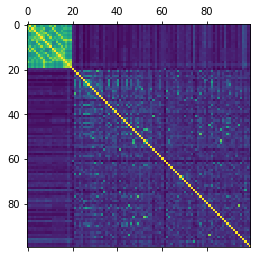

In [15]:
# morgan3_2048_dice
plt.matshow(M_sim_mol[:100,:100])

In [16]:
# Find bette way to keep track of wrong fingerprints!!
exclude_IDs = [1435, 1440, 2232, 2233, 9384, 10791, 10991]

In [17]:
# Transform molecular similarity matrix in 1D array AND remove all excluded IDs
B = np.delete(np.delete(M_sim_mol, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = B.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
B = np.delete(B.reshape(length**2), remove_diagonal)

### Loop through all saved Spec2Vec models for different iterations

In [18]:
def get_similarities_iterations(iterations_cum, 
                                filenames, 
                                save_matrix = None, 
                                save_refscore = None):
    # Run routine for all saved model iterations
    ref_score_Spec2Vec_tests_lst = []
    for i, filename in enumerate(filenames):
        MS_measure.build_model_word2vec(filename, size=300, window=500, 
                                 min_count=1, workers=4, iterations=1, 
                                 use_stored_model=True)

        MS_measure.get_vectors_centroid(method = 'ignore', 
                                 tfidf_weighted = False, 
                                 weighting_power = 0.5, 
                                 tfidf_model = None,
                                 extra_epochs = 1)

        M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')
        if save_matrix is not None:
            np.save(PATH_COMPUTED + save_matrix + str(iterations_cum[i]) + '.npy', M_sim_ctr)

        A = np.delete(np.delete(M_sim_ctr, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
        A = np.delete(A.reshape(length**2), remove_diagonal)

        # Plot against dice score on morgan3 fingerprints   
        ref_score_Spec2Vec = plot_precentile(A, B, num_bins = 1000 , show_top_percentile = 0.5)
        ref_score_Spec2Vec_tests_lst.append(ref_score_Spec2Vec)
        np.save(PATH_COMPUTED + save_refscore + str(iterations_cum[i]) + '.npy', ref_score_Spec2Vec) 
        
    return ref_score_Spec2Vec_tests_lst

Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents. of  10998  documents.10998  documents.  of  10998  documents. 10998  documents.  of  10998  documents.3310  of  10998  documents.10998  documents.10998  documents.10998  documents. 10998  documents.  of  10998  documents. of  10998  documents.  documents. of  10998  documents. of  10998  documents. 10998  documents.  of  10998  documents.10998  documents.10998  documents. documents.  documents.10998  documents. 10998  documents.  of  10998  documents.Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents. of  10998  documents.10998  documents.  of  10998  documents. of  10998  documents. documents.  documents.  of  10998  documents.  documents. 10998  documents. of  10998  documents. of  10998  document

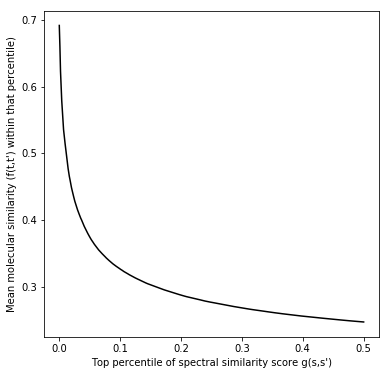

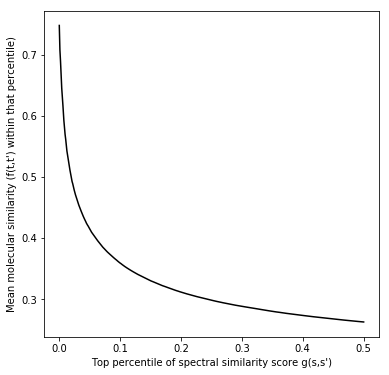

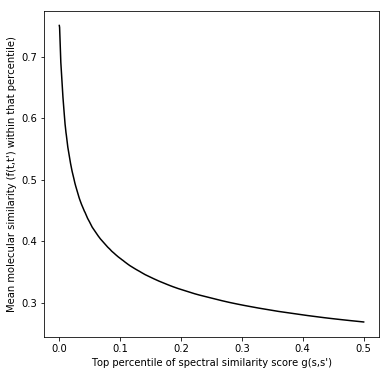

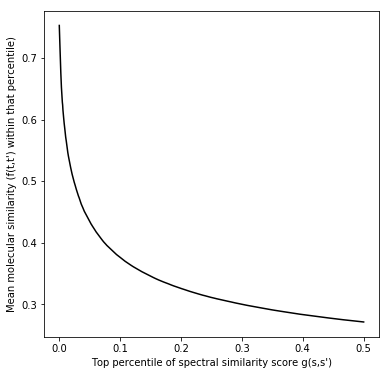

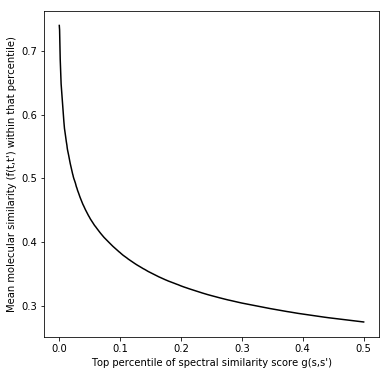

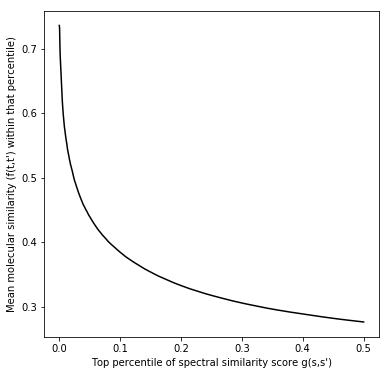

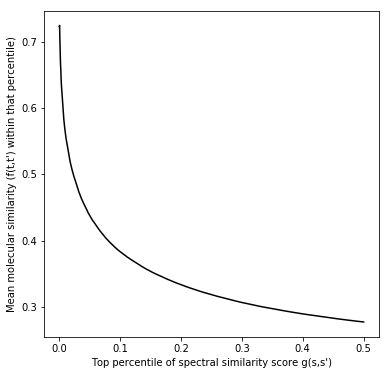

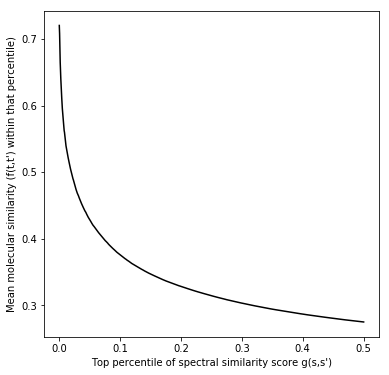

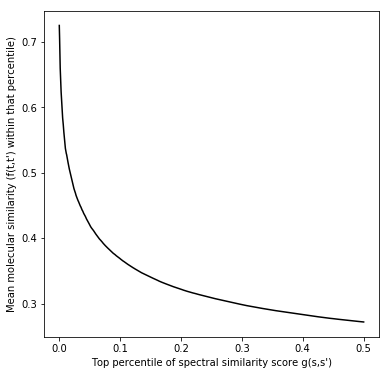

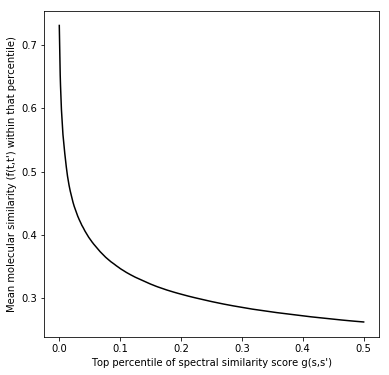

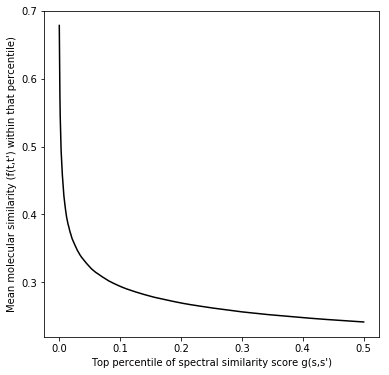

In [24]:
iterations = [2,2,2,4,5,5,5,10,15,25,25]
iterations_cum = [int(x + np.sum(iterations[:i])) for i, x in enumerate(iterations)]

# Create list of filenames of Spec2Vec models saved during training
filename_base = os.path.join(PATH_SAVE_MODEL, 'S2V_uniqueInchikey_pos_d300_w500_neg20_minmax10_1000_dec2_exp08_iter100')
filenames = [filename_base + '_TEMP_' + str(x) + '.model' for x in iterations_cum[:-1]]
filenames.extend([filename_base + '.model'])

ref_score_Spec2Vec_tests_lst_neg20 = get_similarities_iterations(iterations_cum,
                                    filenames, 
                                    save_matrix = 'M_sim_uI_pos_d300_w500_neg20_minmax10_1000_dec2_exp08_iter_', 
                                    save_refscore = 'ref_score_uI_pos_d300_w500_neg20_minmax10_1000_dec2_exp08_iter_')        

Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.998  documents.  of  10998  documents. documents. 10998  documents.  of  10998  documents. 10998  documents. of  10998  documents. of  10998  documents. documents. documents.10998  documents. documents.  of  10998  documents. of  10998  documents.10998  documents. documents. 10998  documents. 8710  of  10998  documents. of  10998  documents.Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents. of  10998  documents.  of  10998  documents.  of  10998  documents.  of  10998  documents. of  10998  documents. of  10998  documents. 10998  documents. of  10998  documents. of  10998  documents. of  10998  documents.  documents.10998  documents. 10998  documents. of  10998  documents.9790  of  10998  documents.

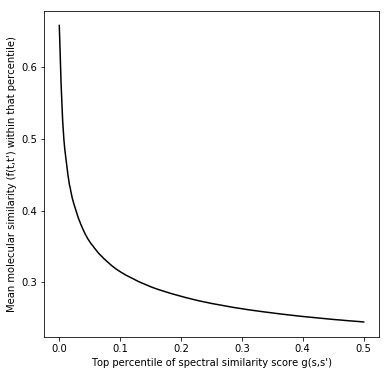

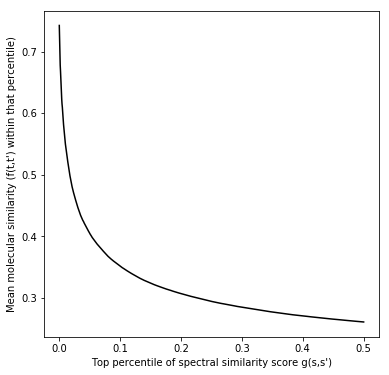

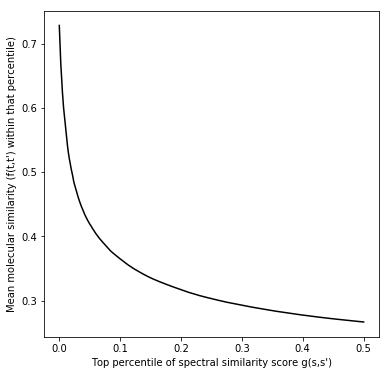

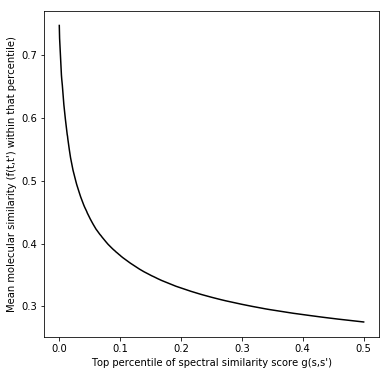

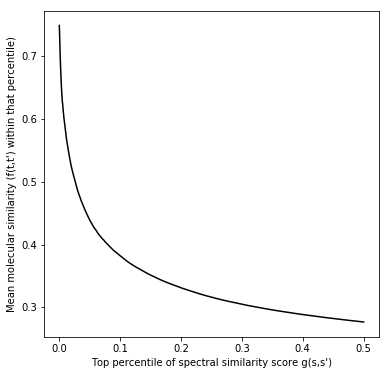

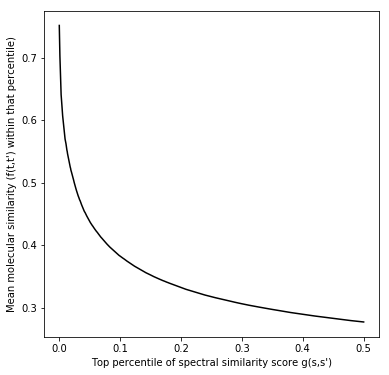

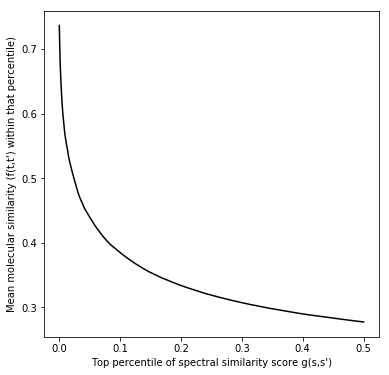

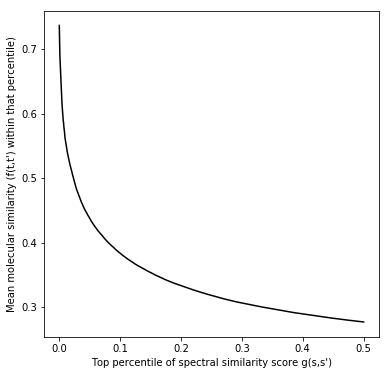

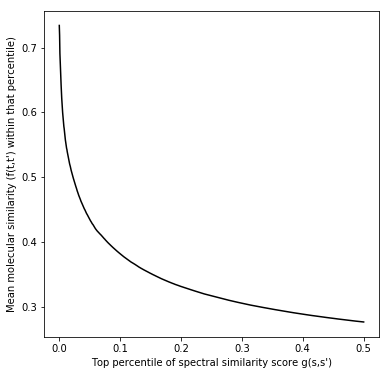

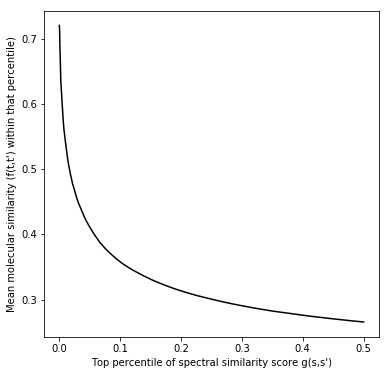

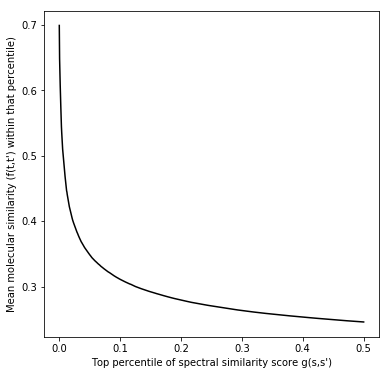

In [25]:
iterations = [2,2,2,4,5,5,5,10,15,25,25]
iterations_cum = [int(x + np.sum(iterations[:i])) for i, x in enumerate(iterations)]

# Create list of filenames of Spec2Vec models saved during training
filename_base = os.path.join(PATH_SAVE_MODEL, 'S2V_uniqueInchikey_pos_d300_w500_neg5_minmax10_1000_dec2_exp08_iter100')
filenames = [filename_base + '_TEMP_' + str(x) + '.model' for x in iterations_cum[:-1]]
filenames.extend([filename_base + '.model'])

ref_score_Spec2Vec_tests_lst_neg5 = get_similarities_iterations(iterations_cum,
                                    filenames, 
                                    save_matrix = 'M_sim_uI_pos_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_', 
                                    save_refscore = 'ref_score_uI_pos_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_')        

Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.f  10998  documents.  of  10998  documents. of  10998  documents. of  10998  documents.  of  10998  documents. of  10998  documents.  documents. of  10998  documents. 10998  documents.10998  documents. of  10998  documents.5540  of  10998  documents. 10998  documents. of  10998  documents. documents.6200  of  10998  documents.10998  documents.  documents.  of  10998  documents.9660  of  10998  documents.10640  of  10998  documents.Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.of  10998  documents.  documents.10998  documents.10998  documents. of  10998  documents.10998  documents. of  10998  documents. of  10998  documents.  documents. of  10998  documents.  of  10998  documents.  documents.1099

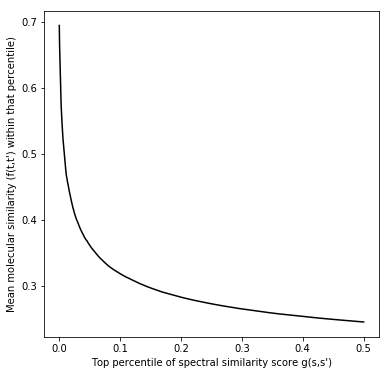

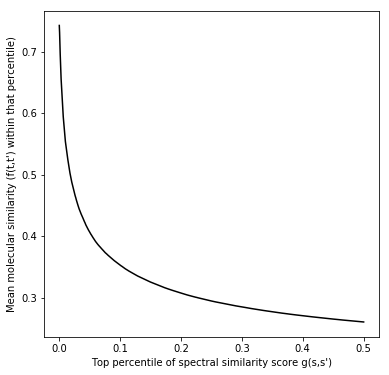

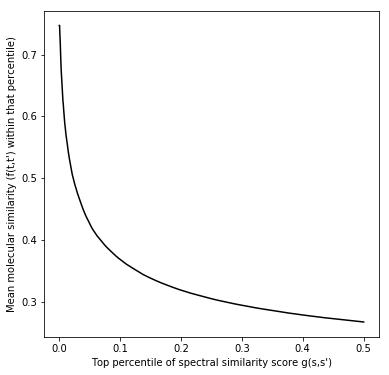

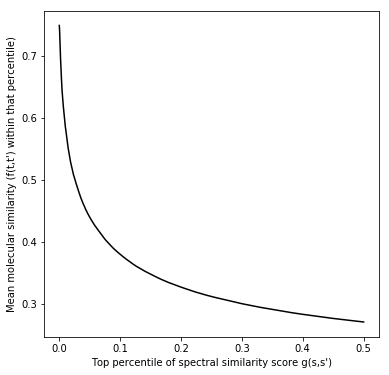

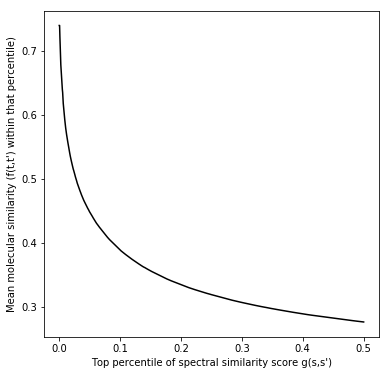

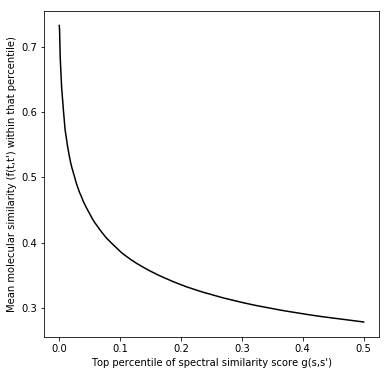

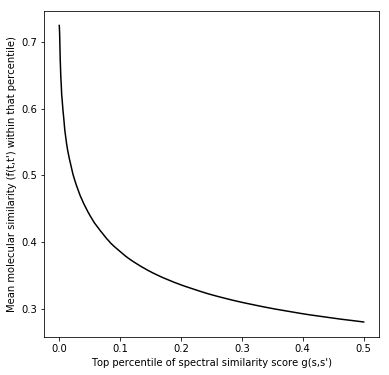

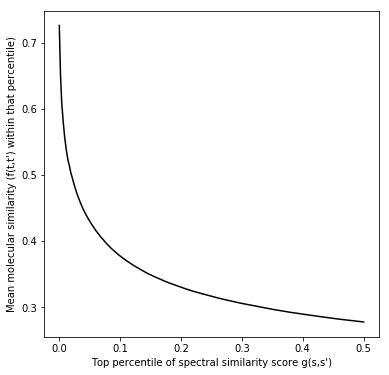

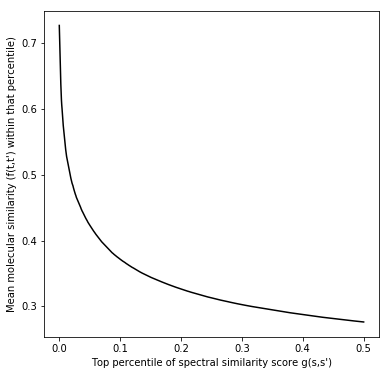

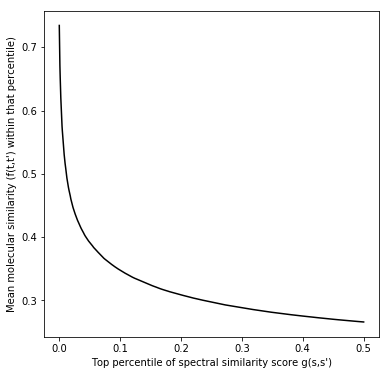

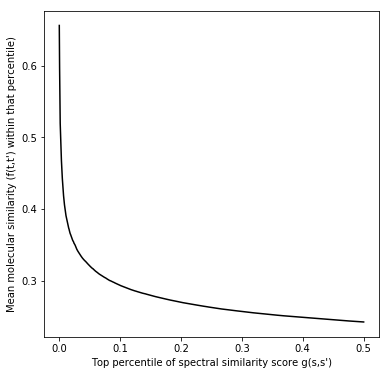

In [26]:
iterations = [2,2,2,4,5,5,5,10,15,25,25]
iterations_cum = [int(x + np.sum(iterations[:i])) for i, x in enumerate(iterations)]

# Create list of filenames of Spec2Vec models saved during training
filename_base = os.path.join(PATH_SAVE_MODEL, 'S2V_uniqueInchikey_pos_d300_w500_neg50_minmax10_1000_dec2_exp08_iter100')
filenames = [filename_base + '_TEMP_' + str(x) + '.model' for x in iterations_cum[:-1]]
filenames.extend([filename_base + '.model'])

ref_score_Spec2Vec_tests_lst_neg50 = get_similarities_iterations(iterations_cum,
                                    filenames, 
                                    save_matrix = 'M_sim_uI_pos_d300_w500_neg50_minmax10_1000_dec2_exp08_iter_', 
                                    save_refscore = 'ref_score_uI_pos_d300_w500_neg50_minmax10_1000_dec2_exp08_iter_')        

Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.documents.  documents.  of  10998  documents. of  10998  documents. documents.10998  documents. 10998  documents.  of  10998  documents.10998  documents.5100  of  10998  documents. documents. of  10998  documents.  of  10998  documents. documents. of  10998  documents. 10998  documents. 10998  documents. of  10998  documents.  documents. of  10998  documents. documents.Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.f  10998  documents. documents.  of  10998  documents. of  10998  documents. 10998  documents.10998  documents.2910  of  10998  documents. of  10998  documents. of  10998  documents.  of  10998  documents.10998  documents.  of  10998  documents.  of  10998  documents. of  10998  docume

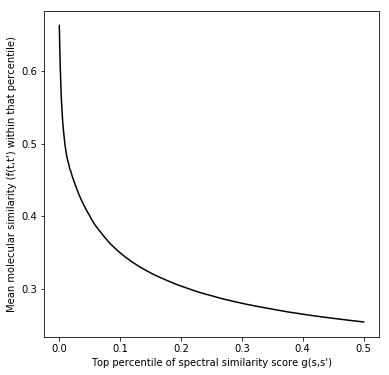

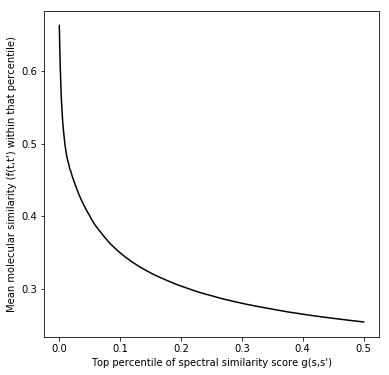

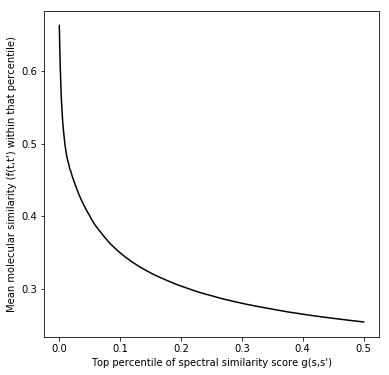

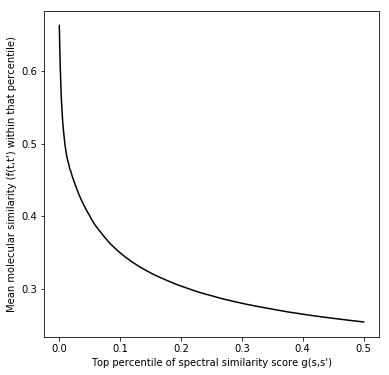

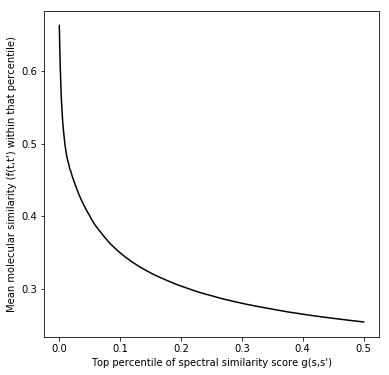

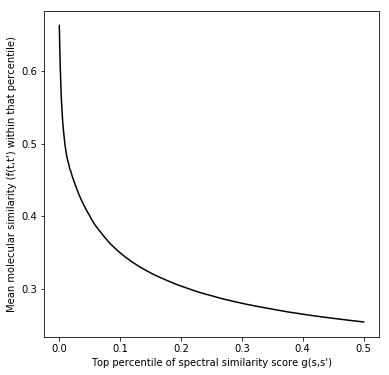

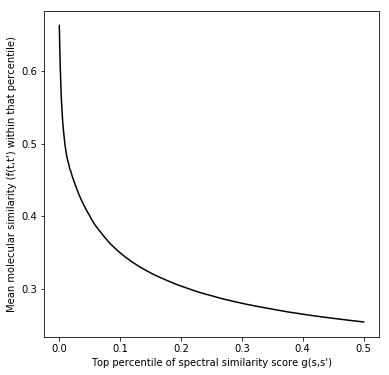

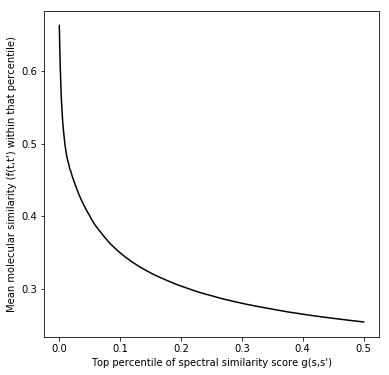

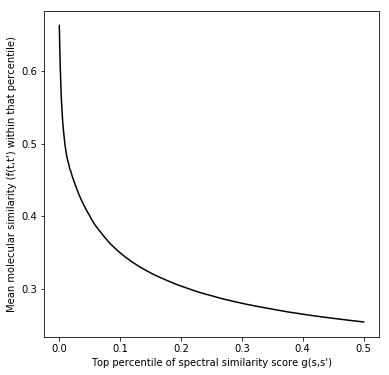

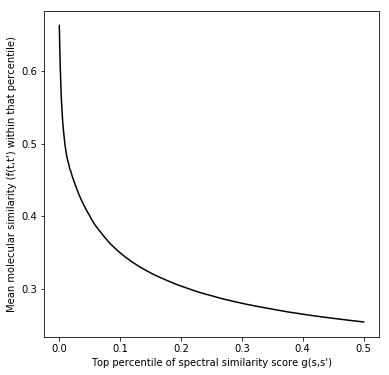

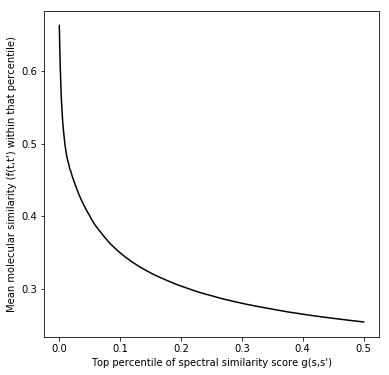

In [27]:
iterations = [2,2,2,4,5,5,5,10,15,25,25]
iterations_cum = [int(x + np.sum(iterations[:i])) for i, x in enumerate(iterations)]

# Create list of filenames of Spec2Vec models saved during training
filename_base = os.path.join(PATH_SAVE_MODEL, 'S2V_uniqueInchikey_pos_d300_w500_neg0_minmax10_1000_dec2_exp08_iter100')
filenames = [filename_base + '_TEMP_' + str(x) + '.model' for x in iterations_cum[:-1]]
filenames.extend([filename_base + '.model'])

ref_score_Spec2Vec_tests_lst_neg0 = get_similarities_iterations(iterations_cum,
                                    filenames, 
                                    save_matrix = 'M_sim_uI_pos_d300_w500_neg0_minmax10_1000_dec2_exp08_iter_', 
                                    save_refscore = 'ref_score_uI_pos_d300_w500_neg0_minmax10_1000_dec2_exp08_iter_')        

### Load some references

In [28]:
ref_score_cum_modcos_minmatch14 = np.load(PATH_COMPUTED + 'spec2vec_uniquesmiles_pos_ModCos_min_match_14.npy')
#ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice = np.load(PATH_COMPUTED + 'ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_2048_dice.npy')
#ref_score_Spec2Vec_uniqueInchikey_pos_exp08_morgan3_dice = np.load('ref_score_Spec2Vec_uniqueInchikey_pos_exp08_morgan3_dice.npy')

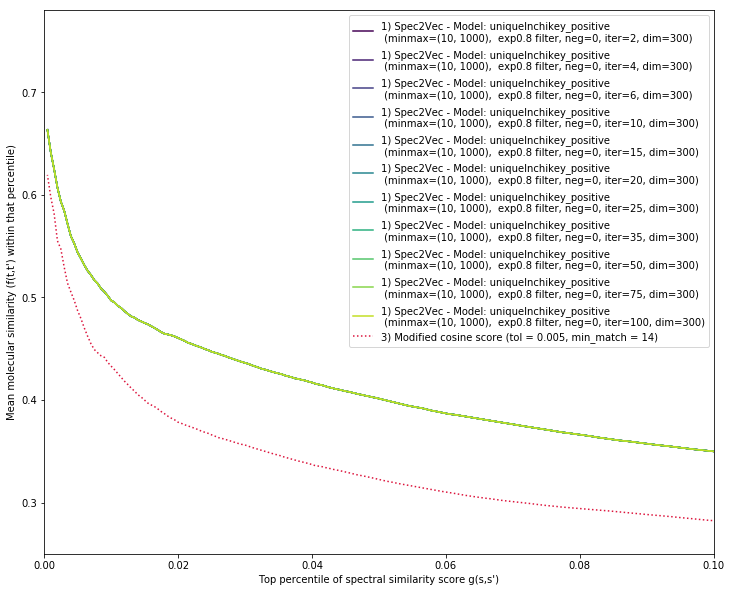

In [48]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

fig, ax = plt.subplots(figsize=(12,10))
cmap = matplotlib.cm.get_cmap('viridis') #'Spectral')
for i, iter in enumerate(iterations_cum):
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst_neg0[i], 
             color= cmap(i/11), #((1-0.08*i), 0.2 + 0.03*i, 0.08*i+0.2), 
             label='1) Spec2Vec - Model: uniqueInchikey_positive \n (minmax=(10, 1000),  exp0.8 filter, neg=0, iter='+str(iter)+', dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_modcos_minmatch14, 
         ':', color='crimson', #'gold', #'crimson',
         label='3) Modified cosine score (tol = 0.005, min_match = 14)')


plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.25, 0.78)
plt.savefig(os.path.join(PATH_OUTPUT, 'Top_percentile_testing_gensim_iterations_neg0_191114.pdf'))

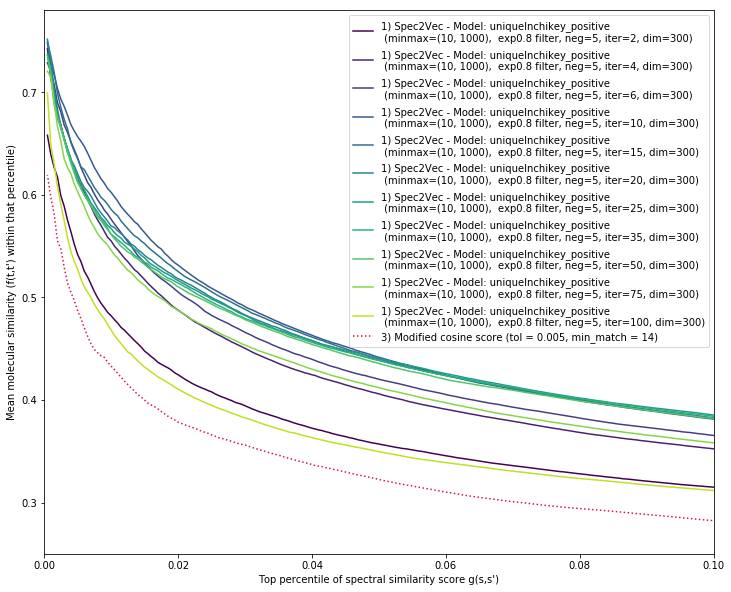

In [47]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

fig, ax = plt.subplots(figsize=(12,10))
cmap = matplotlib.cm.get_cmap('viridis') #'Spectral')
for i, iter in enumerate(iterations_cum):
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst_neg5[i], 
             color= cmap(i/11), #((1-0.08*i), 0.2 + 0.03*i, 0.08*i+0.2), 
             label='1) Spec2Vec - Model: uniqueInchikey_positive \n (minmax=(10, 1000), exp0.8 filter, neg=5, iter='+str(iter)+', dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_modcos_minmatch14, 
         ':', color='crimson', #'gold', #'crimson',
         label='3) Modified cosine score (tol = 0.005, min_match = 14)')

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.25, 0.78)
plt.savefig(os.path.join(PATH_OUTPUT, 'Top_percentile_testing_gensim_iterations_neg5_191114.pdf'))

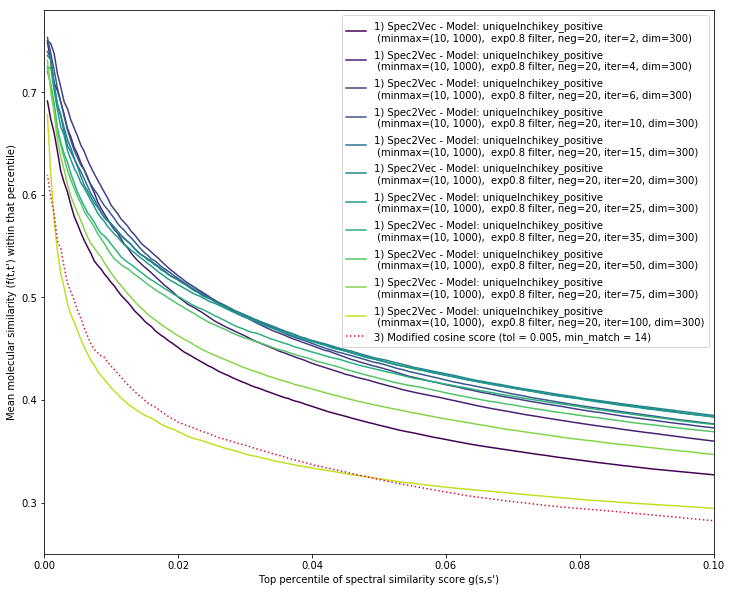

In [46]:
import matplotlib

# Compare all:
num_bins = 1000
show_top_percentile = 0.5

fig, ax = plt.subplots(figsize=(12,10))
cmap = matplotlib.cm.get_cmap('viridis') #'Spectral')
for i, iter in enumerate(iterations_cum):
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst_neg20[i], 
             color= cmap(i/11), #((1-0.08*i), 0.2 + 0.03*i, 0.08*i+0.2), 
             label='1) Spec2Vec - Model: uniqueInchikey_positive \n (minmax=(10, 1000),  exp0.8 filter, neg=20, iter='+str(iter)+', dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_modcos_minmatch14, 
         ':', color='crimson', #'gold', #'crimson',
         label='3) Modified cosine score (tol = 0.005, min_match = 14)')

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.25, 0.78)
plt.savefig(os.path.join(PATH_OUTPUT, 'Top_percentile_testing_gensim_iterations_neg20_191114.pdf'))

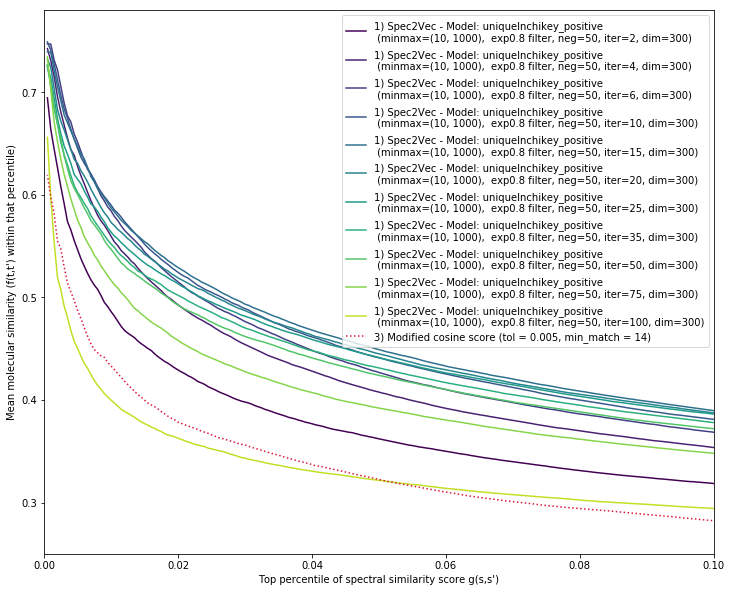

In [49]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

fig, ax = plt.subplots(figsize=(12,10))
cmap = matplotlib.cm.get_cmap('viridis') #'Spectral')
for i, iter in enumerate(iterations_cum):
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst_neg50[i], 
             color= cmap(i/11), #((1-0.08*i), 0.2 + 0.03*i, 0.08*i+0.2), 
             label='1) Spec2Vec - Model: uniqueInchikey_positive \n (minmax=(10, 1000),  exp0.8 filter, neg=50, iter='+str(iter)+', dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_modcos_minmatch14, 
         ':', color='crimson', #'gold', #'crimson',
         label='3) Modified cosine score (tol = 0.005, min_match = 14)')

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.25, 0.78)
plt.savefig(os.path.join(PATH_OUTPUT, 'Top_percentile_testing_gensim_iterations_neg50_191114.pdf'))

### Conclusions
Although it is often considered that longer training will improve the results of a word2vec model, we found that this does not necessarily hold for our Spec2Vec spectral similarity measures. When using negative sampling during the training, model performance was observed to break down after long training runs. At the same time, however, including negative sampling allowed to obtain better overall results. Generally we found that training a model with negative sampling (negative=5 - 50) and 10-25 epochs were well suited for obtaining close to optimal model performance. 

### Show best results

In [82]:
top = 250

print("Negative = 0")
data = np.array(ref_score_Spec2Vec_tests_lst_neg0)[:,-top:]/top
print("max sum:", data.sum(axis=1).max())
ID = np.array(data.sum(axis=1).argmax())
print("max sum found for iter =", iterations_cum[ID], "\n")

print("Negative = 5")
data = np.array(ref_score_Spec2Vec_tests_lst_neg5)[:,-top:]/top
print("max sum:", data.sum(axis=1).max())
ID = np.array(data.sum(axis=1).argmax())
print("max sum found for iter =", iterations_cum[ID], "\n")

print("Negative = 20")
data = np.array(ref_score_Spec2Vec_tests_lst_neg20)[:,-top:]/top
print("max sum:", data.sum(axis=1).max())
ID = np.array(data.sum(axis=1).argmax())
print("max sum found for iter =", iterations_cum[ID], "\n")

print("Negative = 50")
data = np.array(ref_score_Spec2Vec_tests_lst_neg50)[:,-top:]/top
print("max sum:", data.sum(axis=1).max())
ID = np.array(data.sum(axis=1).argmax())
print("max sum found for iter =", iterations_cum[ID], "\n")

Negative = 0
max sum: 0.4020369487736578
max sum found for iter = 2 

Negative = 5
max sum: 0.4497306276566849
max sum found for iter = 10 

Negative = 20
max sum: 0.4457978451994802
max sum found for iter = 20 

Negative = 50
max sum: 0.4543957304260687
max sum found for iter = 15 



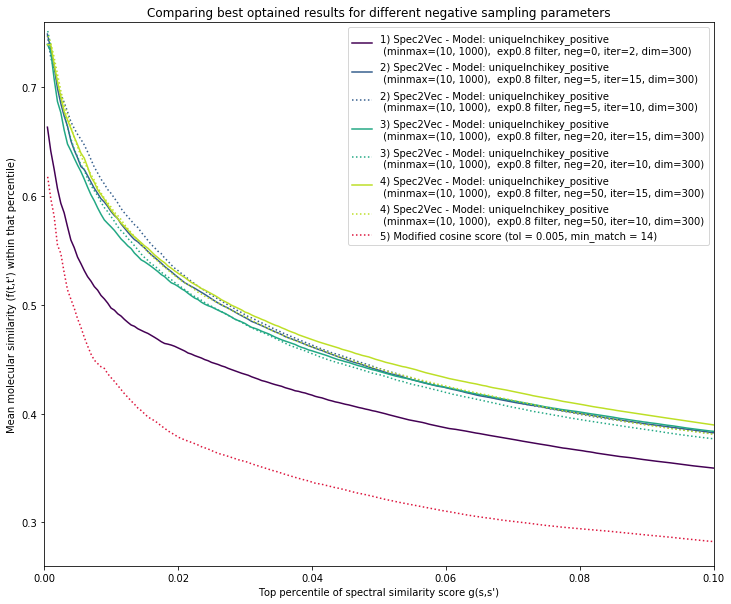

In [97]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

fig, ax = plt.subplots(figsize=(12,10))
cmap = matplotlib.cm.get_cmap('viridis') #'Spectral')
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst_neg0[0], 
         color= cmap(0),
         label='1) Spec2Vec - Model: uniqueInchikey_positive \n (minmax=(10, 1000),  exp0.8 filter, neg=0, iter=2, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst_neg5[4], 
         color= cmap(0.3),
         label='2) Spec2Vec - Model: uniqueInchikey_positive \n (minmax=(10, 1000),  exp0.8 filter, neg=5, iter=15, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst_neg5[3], 
         ':', color= cmap(0.3),
         label='2) Spec2Vec - Model: uniqueInchikey_positive \n (minmax=(10, 1000),  exp0.8 filter, neg=5, iter=10, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst_neg20[4], 
         color= cmap(0.6),
         label='3) Spec2Vec - Model: uniqueInchikey_positive \n (minmax=(10, 1000),  exp0.8 filter, neg=20, iter=15, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst_neg20[3], 
         ':', color= cmap(0.6),
         label='3) Spec2Vec - Model: uniqueInchikey_positive \n (minmax=(10, 1000),  exp0.8 filter, neg=20, iter=10, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst_neg50[4], 
         color= cmap(0.9),
         label='4) Spec2Vec - Model: uniqueInchikey_positive \n (minmax=(10, 1000),  exp0.8 filter, neg=50, iter=15, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst_neg50[3], 
         ':', color= cmap(0.9),
         label='4) Spec2Vec - Model: uniqueInchikey_positive \n (minmax=(10, 1000),  exp0.8 filter, neg=50, iter=10, dim=300)')


plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_modcos_minmatch14, 
         ':', color='crimson', #'gold', #'crimson',
         label='5) Modified cosine score (tol = 0.005, min_match = 14)')

plt.legend()
plt.title('Comparing best optained results for different negative sampling parameters')
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.26, 0.76)
plt.savefig(PATH_OUTPUT + 'Top_percentile_testing_gensim_compare_negative_sampling_191114.pdf')

# 4. Compare to ground truth from daylight (rdkit) fingerprints

In [10]:
filename = os.path.join(PATH_COMPUTED, 'MS_sim_mol_uniqueInchikey_rdkit2048_jaccard_191119.npy')
M_sim_mol = MS_sim_classic.mol_sim_matrix([],
                                       [],
                                       method = 'jaccard',
                                       filename = filename)

Molecular similarity scores found and loaded.


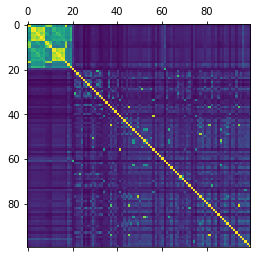

In [11]:
# morgan3_2048_dice
plt.matshow(M_sim_mol[:100,:100])

In [12]:
# Find bette way to keep track of wrong fingerprints!!
exclude_IDs = [1435, 1440, 2232, 2233, 9384, 10791, 10991]

In [13]:
# Transform molecular similarity matrix in 1D array AND remove all excluded IDs
B = np.delete(np.delete(M_sim_mol, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = B.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
B = np.delete(B.reshape(length**2), remove_diagonal)

## Loop through all iterations of model training for neg=5

Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.alculated centroid vectors for  480  of  10998  documents. 10998  documents. 1650  of  10998  documents. 10998  documents.4920  of  10998  documents. documents. 10998  documents.  documents. Calculated centroid vectors for  6840  of  10998  documents. 7010  of  10998  documents.7290  of  10998  documents.  of  10998  documents. documents. 10998  documents. 8410  of  10998  documents.  documents. Calculated centroid vectors for  10570  of  10998  documents.Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.documents. Calculated centroid vectors for  1970  of  10998  documents. 2100  of  10998  documents.3570  of  10998  documents. Calculated centroid vectors for  3910  of  10998  documents.4600  of  1

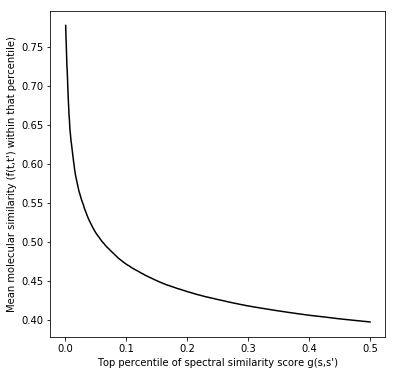

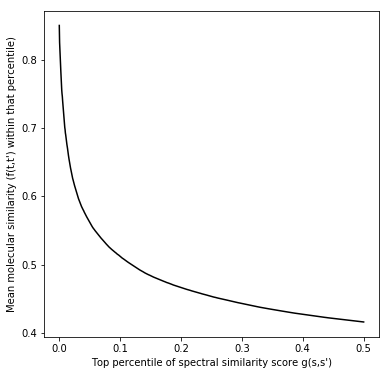

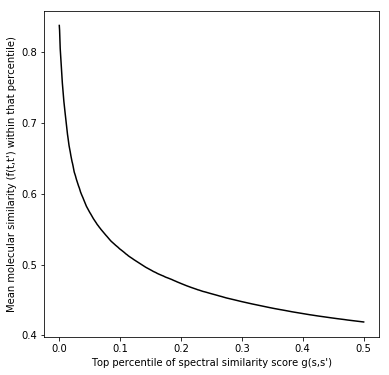

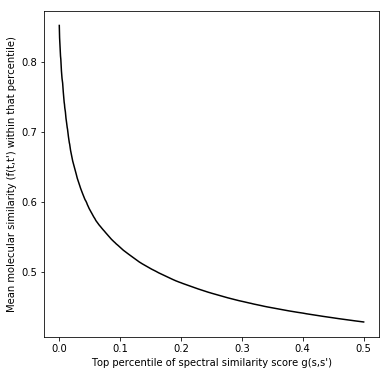

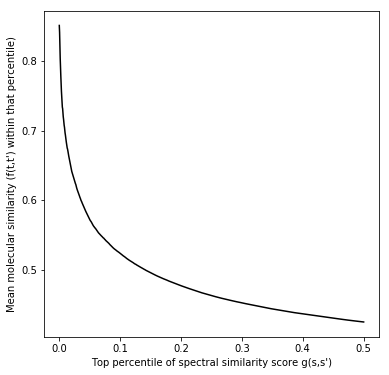

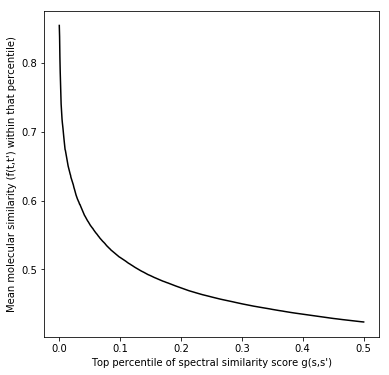

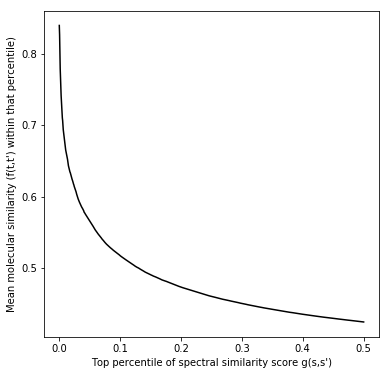

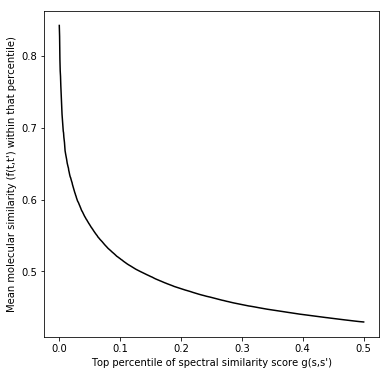

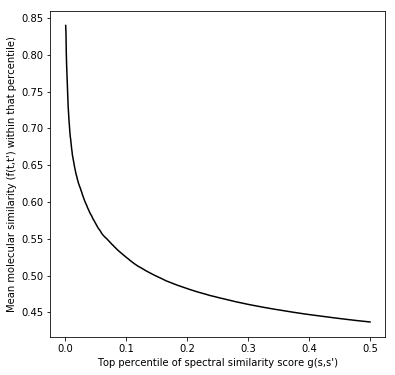

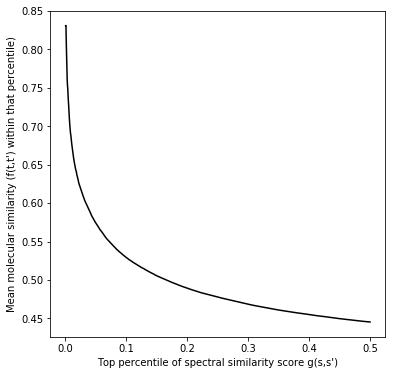

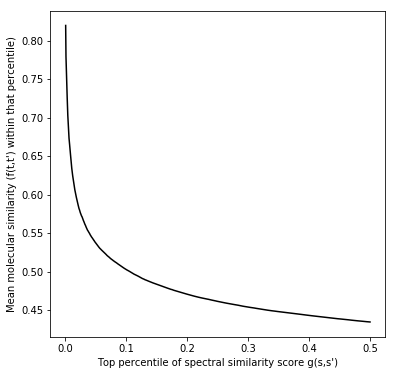

In [20]:
iterations = [2,2,2,4,5,5,5,10,15,25,25]
iterations_cum = [int(x + np.sum(iterations[:i])) for i, x in enumerate(iterations)]

# Create list of filenames of Spec2Vec models saved during training
filename_base = os.path.join(PATH_SAVE_MODEL, 'S2V_uniqueInchikey_pos_d300_w500_neg5_minmax10_1000_dec2_exp08_iter100')
filenames = [filename_base + '_TEMP_' + str(x) + '.model' for x in iterations_cum[:-1]]
filenames.extend([filename_base + '.model'])

S2V_tests_lst_neg5_rdkit2048jac = get_similarities_iterations(iterations_cum,
                                            filenames, 
                                            save_matrix = None, 
                                            save_refscore = 'ref_score_uI_pos_d300_w500_neg5_minmax10_1000_dec2_exp08_rdkit2048jaccard_iter_')        

### Load some references

In [29]:
ref_score_modcos_rdkit_minmatch16 = np.load(PATH_COMPUTED + 's2v_uI_pos_ModCos_rdkit_jaccard_min_match_16.npy')

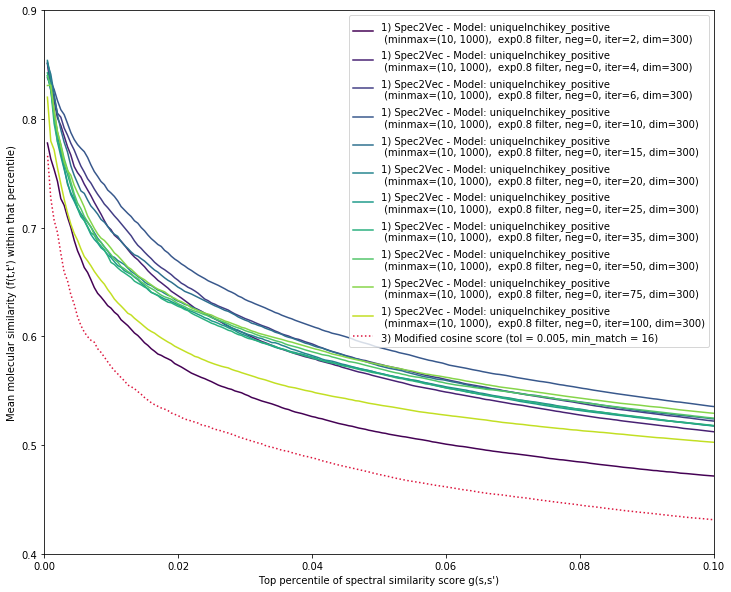

In [30]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

fig, ax = plt.subplots(figsize=(12,10))
cmap = matplotlib.cm.get_cmap('viridis') #'Spectral')
for i, iter in enumerate(iterations_cum):
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], S2V_tests_lst_neg5_rdkit2048jac[i], 
             color= cmap(i/11), #((1-0.08*i), 0.2 + 0.03*i, 0.08*i+0.2), 
             label='1) Spec2Vec - Model: uniqueInchikey_positive \n (minmax=(10, 1000),  exp0.8 filter, neg=0, iter='+str(iter)+', dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_modcos_rdkit_minmatch16, 
         ':', color='crimson', #'gold', #'crimson',
         label='3) Modified cosine score (tol = 0.005, min_match = 16)')


plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.4, 0.9)
plt.savefig(os.path.join(PATH_OUTPUT, 'Top_percentile_uI_rdkit2048jaccard_iterations_neg5_191203.pdf'))

In [11]:
file_model_word2vec = os.path.join(PATH_SAVE_MODEL, 'S2V_uniqueInchikey_pos_d300_w500_iter100_minmax10_500_dec2_minperc01.model')
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=500, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [31]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = False, #True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
No tfidf model found.
  Calculated centroid vectors for  10998  of  10998  documents.f  10998  documents. Calculated centroid vectors for  630  of  10998  documents.10998  documents. of  10998  documents.  documents. 10998  documents. of  10998  documents. documents.  of  10998  documents. of  10998  documents. 4360  of  10998  documents.10998  documents. documents.  documents.  of  10998  documents. documents.  of  10998  documents.  of  10998  documents.10998  documents.  of  10998  documents.10998  documents. Calculated centroid vectors for  8070  of  10998  documents. 10998  documents. Calculated centroid vectors for  9040  of  10998  documents. of  10998  documents.

### Calculate all-vs-all similarity matrix based on Spec2Vec spectra vectors

In [32]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

In [33]:
#np.save(PATH_SAVE_MODEL + 'M_sim_spec2vec_uI_model_tfidf_191110.npy', M_sim_ctr)
np.save(os.path.join(PATH_SAVE_MODEL, 'M_sim_spec2vec_uI_model_191110.npy', M_sim_ctr))

In [37]:
M_sim_ctr = np.load(os.path.join(PATH_SAVE_MODEL, 'M_sim_spec2vec_uI_model_191110.npy'))

In [38]:
M_sim_ctr.shape

(10998, 10998)

# 4. Compare to model trained on allGNPS_positive

Use results from models trained on the entire allGNPS_positive dataset.

### 1) exponential peak intensity filter (exp_intensity_filter = 0.8) + min_peaks,max_peaks = 10,1000

In [98]:
ref_score_Spec2Vec_allGNPS_pos_exp08_morgan3_dice_lst = []

iterations = 10*[10]
iterations = [int(x + np.sum(iterations[:i])) for i, x in enumerate(iterations)]
for iter in iterations:
    ref_score_Spec2Vec = np.load(os.path.join(PATH_COMPUTED, 'ref_score_Spec2Vec_allGNPS_pos_exp08_iter' + str(iter) + '_morgan3_dice.npy'))
    ref_score_Spec2Vec_allGNPS_pos_exp08_morgan3_dice_lst.append(ref_score_Spec2Vec)

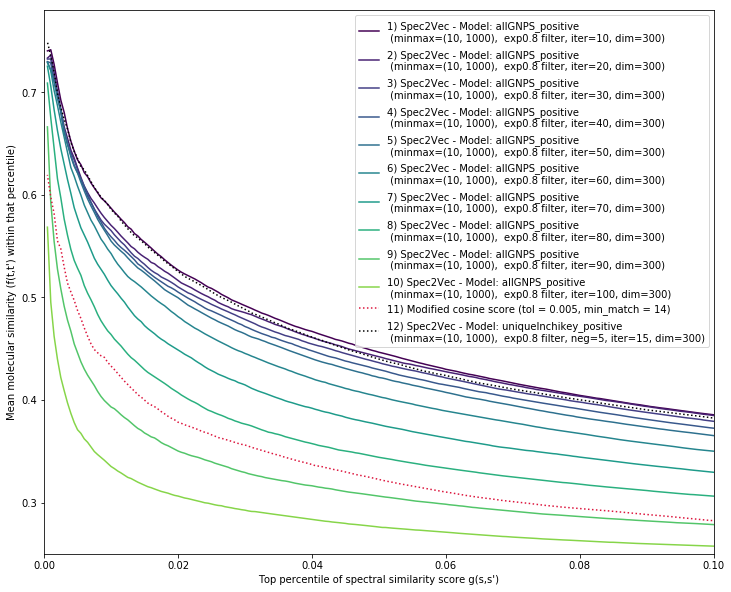

In [106]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

fig, ax = plt.subplots(figsize=(12,10))
cmap = matplotlib.cm.get_cmap('viridis') #'Spectral')
for i, iter in enumerate(iterations):
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_allGNPS_pos_exp08_morgan3_dice_lst[i], 
             color = cmap(i/11), #color= ((1-0.08*i), 0.2, 0.08*i+0.2),
             label= str(i+1) + ') Spec2Vec - Model: allGNPS_positive \n (minmax=(10, 1000),  exp0.8 filter, iter='+str(iter)+', dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_modcos_minmatch14, 
         ':', color= 'crimson',
         label='11) Modified cosine score (tol = 0.005, min_match = 14)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst_neg5[4], 
         ':', color= 'black',
         label='12) Spec2Vec - Model: uniqueInchikey_positive \n (minmax=(10, 1000),  exp0.8 filter, neg=5, iter=15, dim=300)')

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.25, 0.78)
plt.savefig(os.path.join(PATH_OUTPUT, 'Top_percentile_allGNPS_pos_exp08_iter_191114.pdf'))

### 2) relative peak intensity filter (1% max intensity) + min_peaks,max_peaks = 10,1000

In [107]:
ref_score_Spec2Vec_allGNPS_pos_minperc1_morgan3_dice_lst = []

iterations = 10*[10]
iterations = [int(x + np.sum(iterations[:i])) for i, x in enumerate(iterations)]
for iter in iterations:
    ref_score_Spec2Vec = np.load(PATH_COMPUTED + 'ref_score_Spec2Vec_allGNPS_pos_minperc1_iter' + str(iter) + '_morgan3_dice.npy')
    ref_score_Spec2Vec_allGNPS_pos_minperc1_morgan3_dice_lst.append(ref_score_Spec2Vec)

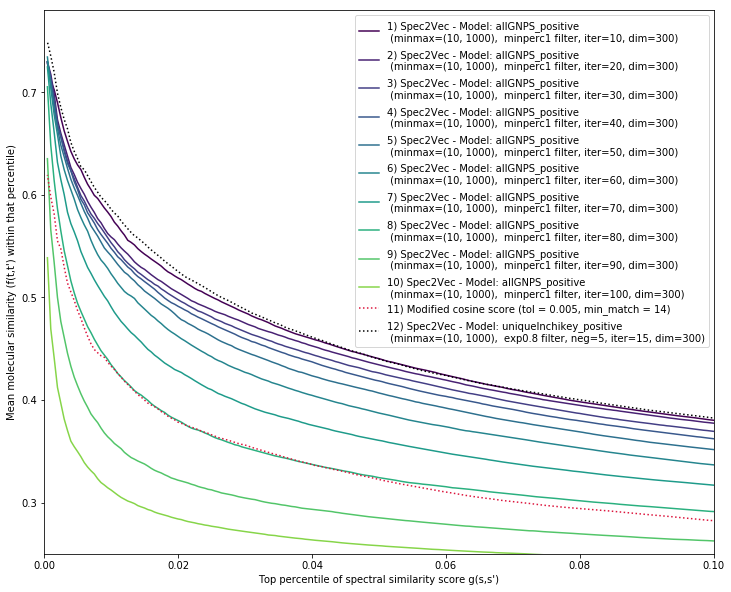

In [109]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

fig, ax = plt.subplots(figsize=(12,10))
cmap = matplotlib.cm.get_cmap('viridis')
for i, iter in enumerate(iterations):
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_allGNPS_pos_minperc1_morgan3_dice_lst[i], 
             color = cmap(i/11), #color= ((1-0.08*i), 0.2, 0.08*i+0.2),
             label= str(i+1) + ') Spec2Vec - Model: allGNPS_positive \n (minmax=(10, 1000),  minperc1 filter, iter='+str(iter)+', dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_modcos_minmatch14, 
         ':', color= 'crimson',
         label='11) Modified cosine score (tol = 0.005, min_match = 14)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst_neg5[4], 
         ':', color= 'black',
         label='12) Spec2Vec - Model: uniqueInchikey_positive \n (minmax=(10, 1000),  exp0.8 filter, neg=5, iter=15, dim=300)')

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.25, 0.78)
plt.savefig(os.path.join(PATH_OUTPUT, 'Top_percentile_allGNPS_pos_minperc1_iter_191114.pdf'))

# Testing Gensim parameters for word2vec model

Some semi worked out observations.  
+ A skip-gram model did not work better for me than a CBOW model (which is what was used by us until now).   
+ The loss given by Gensim seems to diverge! Not sure why? --> probably gensim gives cummulative loss!
+ cbow_mean = 0 did not improve things.
+ 

In [3]:
file_json = os.path.join(PATH_MS_DATA, "uniqueInchikey_positive_minmax_10_1000_2dec_exp08_191110.json")
file_mgf = os.path.join(PATH_MS_DATA, "allGNPS_positive_uniqueInchikey_191107.mgf")

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0.0, #0.1,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000, #None, #500,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [4]:
from similarity_measure import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents)
MS_measure.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  116344


Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.alculated centroid vectors for  440  of  10998  documents.  of  10998  documents. documents.  of  10998  documents.10998  documents. Calculated centroid vectors for  9330  of  10998  documents. of  10998  documents. of  10998  documents.Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.of  10998  documents.1780  of  10998  documents. 4080  of  10998  documents. 5240  of  10998  documents. of  10998  documents. Calculated centroid vectors for  6850  of  10998  documents. 10998  documents. 9850  of  10998  documents.Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.of  10998  docume

TypeError: 'int' object is not iterable

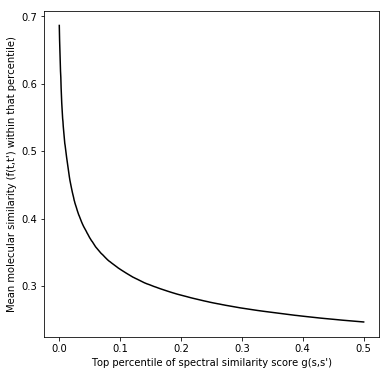

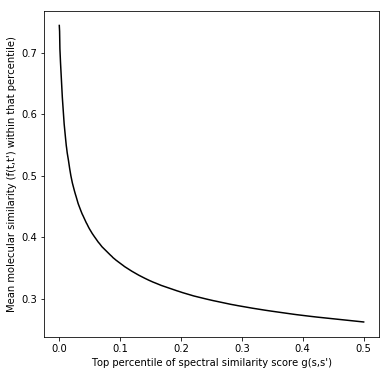

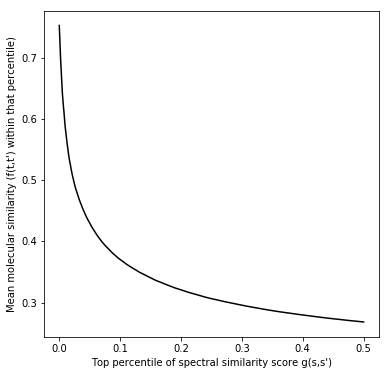

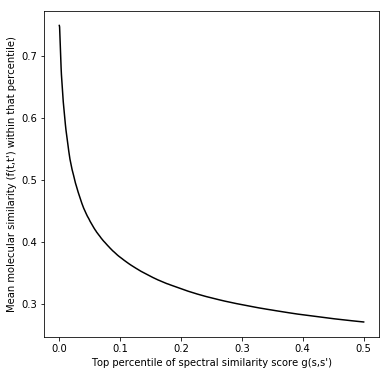

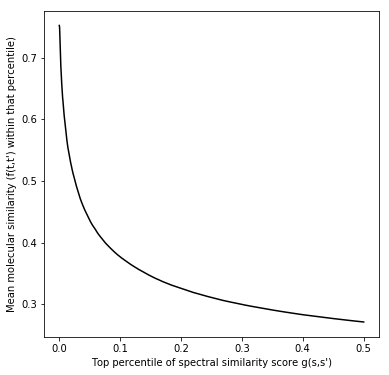

In [61]:
ref_score_Spec2Vec_tests_lst = []

iterations = 10*[2]
iterations = [int(x + np.sum(iterations[:i])) for i, x in enumerate(iterations)]
filename_base = PATH_SAVE_MODEL + 'just_testing_neg20_TEMP_'
filenames = [filename_base + str(x) + '.model' for x in iterations]
filenames.extend([filename_base + '.model'])

for i, filename in enumerate(filenames):
    MS_measure.build_model_word2vec(filename, size=300, window=500, 
                             min_count=1, workers=4, iterations=iterations[0], 
                             use_stored_model=True)
    
    MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = False, #True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)
    
    M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')
    np.save(os.path.join(PATH_COMPUTED, 'M_sim_just_testing_neg20_TEMP_' + str(iterations[i]) + '_191113.npy'), M_sim_ctr)
    
    A = np.delete(np.delete(M_sim_ctr, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
    A = np.delete(A.reshape(length**2), remove_diagonal)
    
    # Plot against dice score on morgan3 fingerprints   
    ref_score_Spec2Vec = plot_precentile(A, B, num_bins = 1000 , show_top_percentile = 0.5)
    ref_score_Spec2Vec_tests_lst.append(ref_score_Spec2Vec)
    np.save(os.path.join(PATH_COMPUTED, 'ref_score_just_testing_neg20_TEMP_' + str(iterations[i]) + '_morgan3_dice.npy'), ref_score_Spec2Vec)
    

Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.documents. 10998  documents.  documents. 10998  documents. documents.  documents.Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.10998  documents.10998  documents. of  10998  documents. Calculated centroid vectors for  7610  of  10998  documents. of  10998  documents.10390  of  10998  documents.Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.of  10998  documents.  documents.  documents.  documents. of  10998  documents. of  10998  documents. documents.  of  10998  documents.  of  10998  documents. 10998  documents.  of  10998  documents. of  10998  documents. documents.Load st

TypeError: 'int' object is not iterable

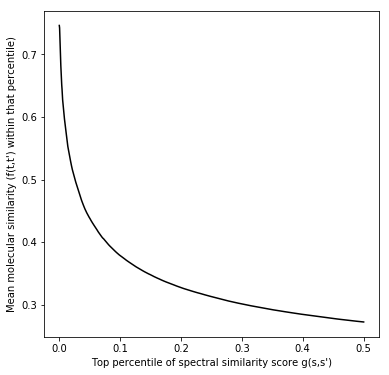

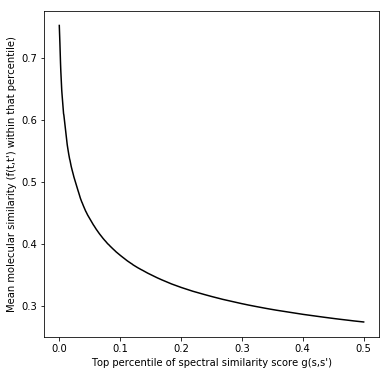

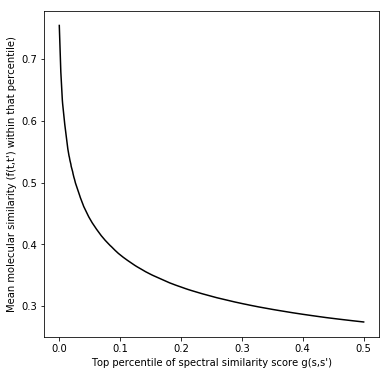

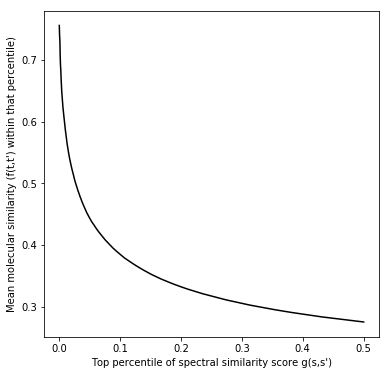

In [72]:
for i, filename in enumerate(filenames[5:]):
    MS_measure.build_model_word2vec(filename, size=300, window=500, 
                             min_count=1, workers=4, iterations=iterations[0], 
                             use_stored_model=True)
    
    MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = False, #True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)
    
    M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')
    np.save(os.path.join(PATH_COMPUTED, 'M_sim_just_testing_neg20_TEMP_' + str(iterations[5+i]) + '_191113.npy'), M_sim_ctr)
    
    A = np.delete(np.delete(M_sim_ctr, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
    A = np.delete(A.reshape(length**2), remove_diagonal)
    
    # Plot against dice score on morgan3 fingerprints   
    ref_score_Spec2Vec = plot_precentile(A, B, num_bins = 1000 , show_top_percentile = 0.5)
    ref_score_Spec2Vec_tests_lst.append(ref_score_Spec2Vec)
    np.save(os.path.join(PATH_COMPUTED, 'ref_score_just_testing_neg20_TEMP_' + str(iterations[5+i]) + '_morgan3_dice.npy'), ref_score_Spec2Vec)
    

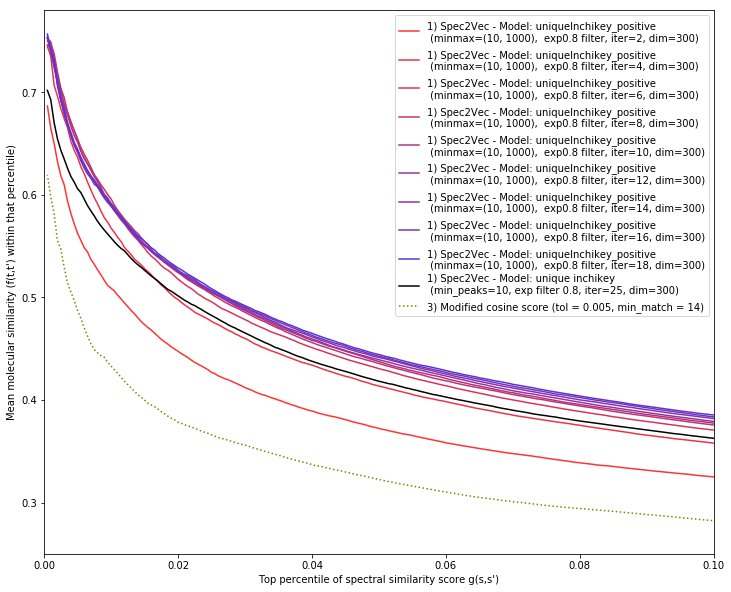

In [75]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

fig, ax = plt.subplots(figsize=(12,10))

for i, iter in enumerate(iterations[:9]):
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst[i], 
             color= ((1-0.08*i), 0.2, 0.08*i+0.2),
             label='1) Spec2Vec - Model: uniqueInchikey_positive \n (minmax=(10, 1000),  exp0.8 filter, iter='+str(iter)+', dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uniqueInchikey_pos_exp08_morgan3_dice, 
         color='black',
         label='1) Spec2Vec - Model: unique inchikey \n (min_peaks=10, exp filter 0.8, iter=25, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_modcos_minmatch14, 
         ':', color='olive', #'crimson',
         label='3) Modified cosine score (tol = 0.005, min_match = 14)')


plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.25, 0.78)
plt.savefig(os.path.join(PATH_OUTPUT, 'Top_percentile_testing_gensim_parameters_191113.pdf'))